# Plotting light curves with best fit model, and allan variance plots
- Read the K2 and Ground-based data from saved csv files from our MCMC analysis
- Plot the K2 and Ground-based light curves, the best fit models from MCMC, and allan variance plots for K2-28b and K2-100b, respectively

In [1]:
# ---------- Graphics ------------
# matplotlib
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=0.5,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=4
rcParams['xtick.minor.width']=0.5
rcParams['xtick.minor.size']=2
rcParams['xtick.direction'] = "in"
rcParams['ytick.direction'] = "in"
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=4
rcParams['ytick.minor.width']=0.5
rcParams['ytick.minor.size']=2

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
        sys.path.append("/Users/gks/programs/MCcubed2/MCcubed/")
    except Exception as e:
        print(e)
        print("Paths already removed")
        
# *****users must set this*******
# Add path to mc3 
sys.path.append("/Users/Sophie/git/MCcubed/")
sys.path.append("../src/")
import MCcubed as mc3 

from priors import PriorSet, UP, NP, JP
import trf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils
import allanvariancemc_modified 

# Read the Ground and K2 data for k2-28b and k2-100b

In [2]:
df_ground = pd.read_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_ground_final.csv",sep=",",header=0)
df_k2 = pd.read_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_k2_final.csv",sep=",",header=0)

df_ground_k2_100b = pd.read_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_ground_final.csv",sep=",",header=0)
df_k2_k2_100b = pd.read_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_k2_final.csv",sep=",",header=0)

# Plot

/Users/gks/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


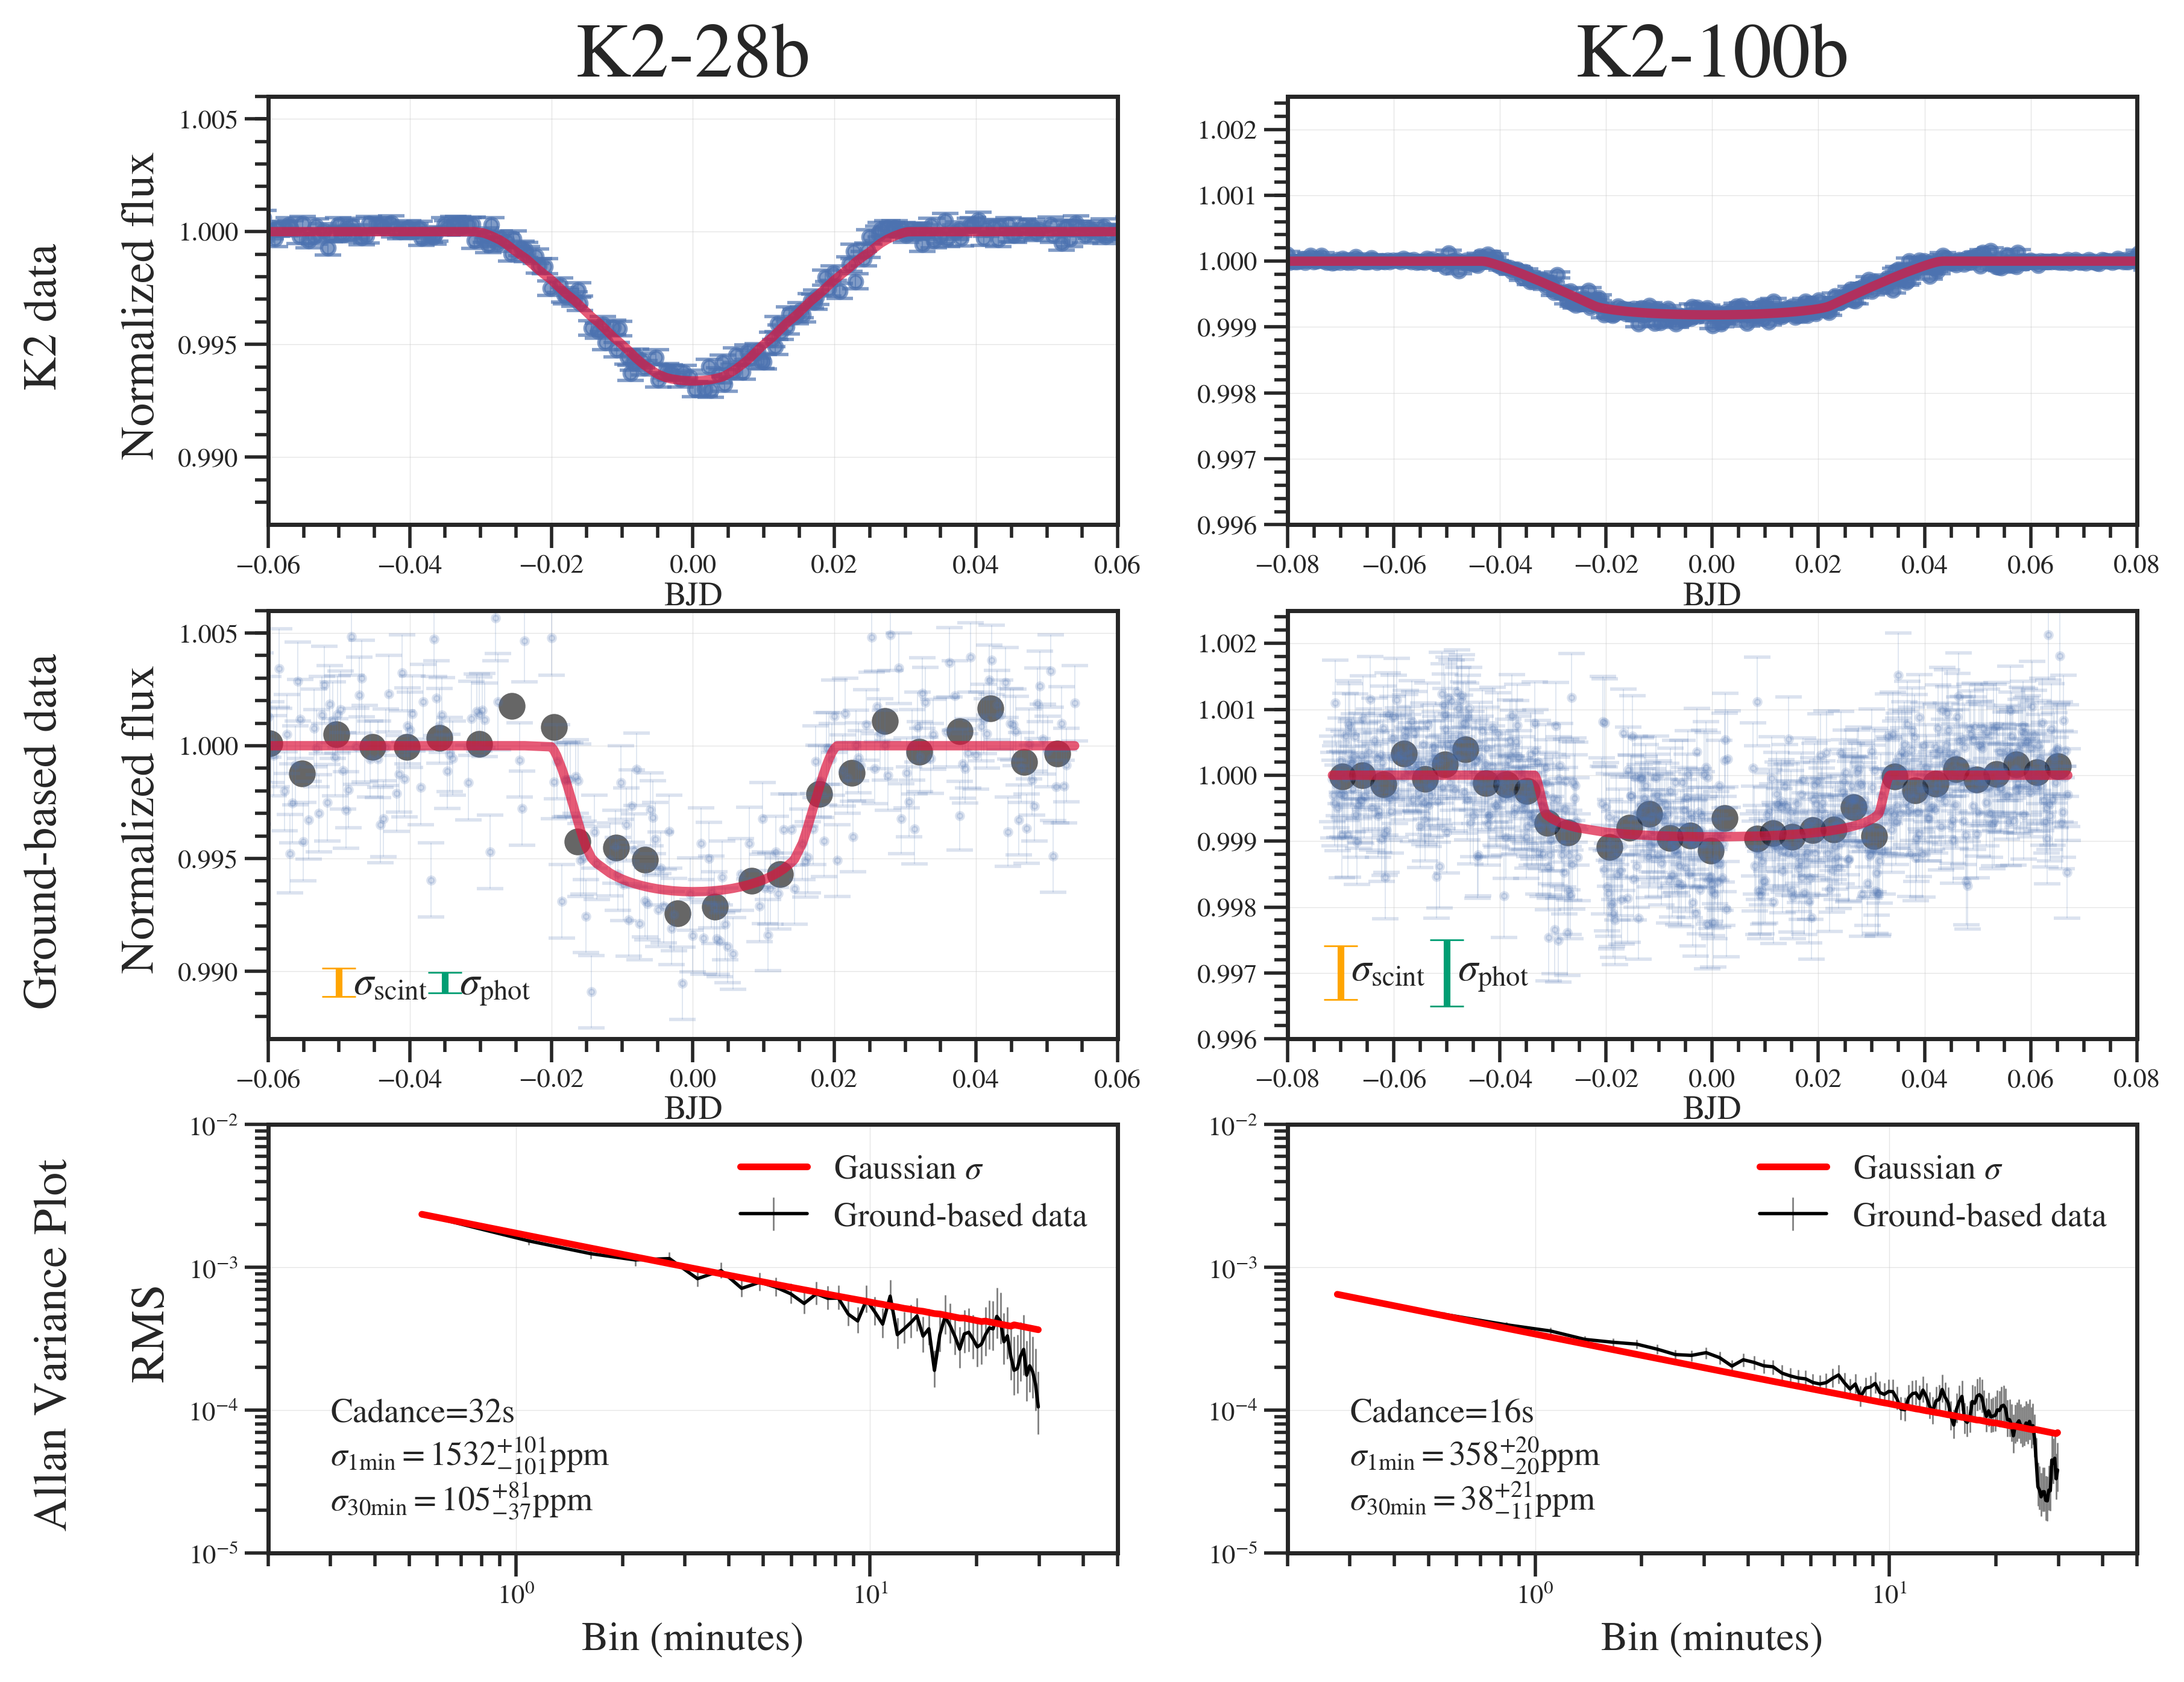

In [3]:
import plot_transits
# create a 6 panel plot
fig, axx = plt.subplots(nrows=3,ncols=2,figsize=(10,8),dpi=200)
(ax,bx),(dx,ex),(gx,hx) = axx

# Obtain period and cadance values from joint analysis
p_k2_28b = 2.26050002261
p_k2_100b= 1.6739026

cadance_k2_28b = 32.5728267431
cadance_k2_100b= 16.5888056159

##################################################################################
# K2-28b
##################################################################################
#k2-28b light curve and allan variance plot
k2_28_t0 = df_ground['xmodel_ground'][np.argmin(df_ground['ymodel_ground'])]

plot_transits.plot_transit_with_model(df_k2['phase_fold_time_k2']*p_k2_28b,
                        df_k2['phase_fold_scaled_flux_k2'],
                        df_k2['scaled_error_k2'],
                        yresidual=None,
                        xmodel=df_k2['xmodel_k2']*p_k2_28b,
                        ymodel=df_k2['ymodel_k2'],ax=ax)
plot_transits.plot_transit_with_model(df_ground['time_ground']-k2_28_t0,
                        df_ground['scaled_flux_ground'],
                        df_ground['scaled_error_ground'],
                        yresidual=None,
                        xmodel=df_ground['xmodel_ground']-k2_28_t0,
                        ymodel=df_ground['ymodel_ground'],
                        offset=0.975,ax=dx,alpha=0.2,markersize=2.)
df_k2_28b = utils.bin_data(df_ground['time_ground']-k2_28_t0,df_ground['scaled_flux_ground'],int(5.*60./cadance_k2_28b))
dx.plot(df_k2_28b.x,df_k2_28b.y,lw=0,marker="o",markersize=8,alpha=0.6,color="black",zorder=1)

# Values from Ground-based analysis
final_unbinned_phot_noise = 0.000451952380952
final_unbinned_scint_noise = 0.000619102949387
x0 = -0.07
dx.errorbar(x0+0.01+0.01,0.9975-0.008,yerr=final_unbinned_scint_noise,elinewidth=2,color='orange',mew=0.5,capsize=5)
dx.errorbar(x0+0.025+0.01,0.9975-0.008,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5,capsize=5)
dx.text(x0+0.01+0.01+0.002,0.99741-0.0084,r"$\sigma_{\mathrm{scint}}$",fontsize=12)
dx.text(x0+0.025+0.01+0.002,0.99741-0.0084,r"$\sigma_{\mathrm{phot}}$",fontsize=12)

red = np.array(df_ground['yresidual_ground'])
# Generate residuals signal:
N = len(red)
# Compute the residuals rms-vs-binsize:
maxbins = int(1800/cadance_k2_28b)
rms, rmslo, rmshi, stderr, binsz = mc3.rednoise.binrms(red, maxbins)
gx.errorbar(binsz*cadance_k2_28b/60., rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5',
            capsize=0, label="Ground-based data",zorder=3,elinewidth=0.5,lw=1)
gx.loglog(binsz*cadance_k2_28b/60., stderr, color='red', ls='-', lw=2, label="Gaussian $\sigma$",zorder=5)
handles,labels = gx.get_legend_handles_labels()
handles = [handles[0],  handles[1]]
labels = [labels[0],  labels[1]]
gx.legend(handles,labels,loc="upper right",fontsize=10)
gx.set_xlabel("Bin (minutes)", fontsize=12)
gx.set_ylabel("RMS", fontsize=9)
label_28b_1min = "$\sigma_{1\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms[1]*1e6,rmshi[1]*1e6,rmslo[1]*1e6)
gx.text(0.3,4e-5,'Cadance={}s\n'.format(int(cadance_k2_28b))+label_28b_1min,fontsize=10)
label_28b_30min = "$\sigma_{30\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms[-1]*1e6,rmshi[-1]*1e6,rmslo[-1]*1e6)
gx.text(0.3,2e-5,label_28b_30min,fontsize=10)


##################################################################################
# K2-100b
##################################################################################
#k2-100b light curve and allan variance plot
k2_100_t0 = df_ground_k2_100b['xmodel_ground'][np.argmin(df_ground_k2_100b['ymodel_ground'])]
plot_transits.plot_transit_with_model(df_k2_k2_100b['phase_fold_time_k2']*p_k2_100b,
                        df_k2_k2_100b['phase_fold_scaled_flux_k2'],
                        df_k2_k2_100b['scaled_error_k2'],
                        yresidual=None,
                        xmodel=df_k2_k2_100b['xmodel_k2']*p_k2_100b,
                        ymodel=df_k2_k2_100b['ymodel_k2'],ax=bx,offset=0.9985)
plot_transits.plot_transit_with_model(df_ground_k2_100b['time_ground']-k2_100_t0,
                        df_ground_k2_100b['scaled_flux_ground'],
                        df_ground_k2_100b['scaled_error_ground'],
                        yresidual=None,
                        xmodel=df_ground_k2_100b['xmodel_ground']-k2_100_t0,
                        ymodel=df_ground_k2_100b['ymodel_ground'],
                        offset=0.9925,ax=ex,alpha=0.2,markersize=2.)
df_k2_100b = utils.bin_data(df_ground_k2_100b['time_ground']-k2_100_t0,df_ground_k2_100b['scaled_flux_ground'],int(5.*60./cadance_k2_100b))
ex.plot(df_k2_100b.x,df_k2_100b.y,lw=0,marker="o",markersize=8,alpha=0.6,color="black",zorder=1)

# values from Ground-based analysis
final_unbinned_phot_noise = 0.000501696719522
final_unbinned_scint_noise = 0.000408551831247
x0 = -0.08
ex.errorbar(x0+0.01,0.997,yerr=final_unbinned_scint_noise,elinewidth=2,color='orange',mew=0.5,capsize=5)
ex.errorbar(x0+0.03,0.997,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5,capsize=5)
ex.text(x0+0.01+0.002,0.9969,r"$\sigma_{\mathrm{scint}}$",fontsize=12)
ex.text(x0+0.03+0.002,0.9969,r"$\sigma_{\mathrm{phot}}$",fontsize=12)


# (Sinusoidal) time-correlated signal:
red_100b = np.array(df_ground_k2_100b['yresidual_ground'])
# Generate residuals signal:
N_100b=len(red_100b)

# Compute the residuals rms-vs-binsize:
maxbins_100b = int(1800/cadance_k2_100b)
rms_100b, rmslo_100b, rmshi_100b, stderr_100b, binsz_100b = mc3.rednoise.binrms(red_100b, maxbins_100b)
hx.errorbar(binsz_100b*cadance_k2_100b/60., rms_100b, yerr=[rmslo_100b, rmshi_100b], fmt="k-",
            ecolor='0.5', capsize=0, label="Ground-based data",zorder=2,elinewidth=0.5,lw=1)
hx.loglog(binsz_100b*cadance_k2_100b/60., stderr_100b, color='red', ls='-', lw=2, label="Gaussian $\sigma$",zorder=5)
handles_100b, labels_100b = hx.get_legend_handles_labels()
handles_100b = [handles_100b[0], handles_100b[1]]
labels_100b = [labels_100b[0], labels_100b[1]]
hx.legend(handles_100b,labels_100b,loc="upper right",fontsize=10)
hx.set_xlabel("Bin (minutes)", fontsize=12)
hx.set_ylabel("RMS", fontsize=9)

# 1 min cadence
label_100b_1min = "$\sigma_{1\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms_100b[3]*1e6,rmshi_100b[3]*1e6,rmslo_100b[3]*1e6)
hx.text(0.3,4e-5,'Cadance={}s\n'.format(int(cadance_k2_100b))+label_100b_1min,fontsize=10)
label_100b_30min = "$\sigma_{30\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms_100b[-1]*1e6,rmshi_100b[-1]*1e6,rmslo_100b[-1]*1e6)
hx.text(0.3,2e-5,label_100b_30min,fontsize=10)

# Set axes labels and titles
axes = [ax,bx,dx,ex,gx,hx]
[axx.tick_params(axis='both',labelsize=8,pad=2) for axx in axes];
ax.set_title("K2-28b")
bx.set_title("K2-100b")
ax.set_ylabel("K2 data \n \n Normalized flux",fontsize=14)
dx.set_ylabel("Ground-based data \n \n Normalized flux",fontsize=14)
gx.set_ylabel("Allan Variance Plot \n \n RMS",fontsize=14)

for axx in [gx,hx]:
    axx.set_ylim(1e-5,1e-2)
    axx.set_xlim(0.2,50.)
    #ix.set_ylim(0,10)
for axx in [bx,ex,hx]:
    axx.set_ylabel("")
for axx in [ax,bx,dx,ex]:
    axx.set_xlabel("BJD",fontsize=10,labelpad=1)
for axx in axes:
    axx.grid(lw=0.25,alpha=0.5)

# K2-28b
ax.set_xlim(-0.06,0.06)
ax.set_ylim(0.987,1.006)
dx.set_xlim(-0.06,0.06)
dx.set_ylim(0.987,1.006)

# K2-100b
bx.set_xlim(-0.08,0.08)
bx.set_ylim(0.996,1.0025)
ex.set_xlim(-0.08,0.08)
ex.set_ylim(0.996,1.0025)

#plt.tight_layout()
plt.savefig('../figures/6_panel_plot.pdf',format='pdf')

In [4]:
### Take a look at precision

In [5]:
print('K2-28b error at 1min: ' + label_28b_1min)
print('K2-28b error at 30min: ' + label_28b_30min)
print('K2-28b Gaussian error at 30min: {:0.1f}ppm'.format(stderr[-1]*1e6))

print('\n###\n')
print('K2-100b error at 1min: ' + label_100b_1min)
print('K2-100b error at 30min: ' + label_100b_30min)
print('K2-100b Gaussian error at 30min: {:0.1f}ppm'.format(stderr_100b[-1]*1e6))

K2-28b error at 1min: $\sigma_{1\mathrm{min}} = 1532^{+101}_{-101}$ppm
K2-28b error at 30min: $\sigma_{30\mathrm{min}} = 105^{+81}_{-37}$ppm
K2-28b Gaussian error at 30min: 365.4ppm

###

K2-100b error at 1min: $\sigma_{1\mathrm{min}} = 358^{+20}_{-20}$ppm
K2-100b error at 30min: $\sigma_{30\mathrm{min}} = 38^{+21}_{-11}$ppm
K2-100b Gaussian error at 30min: 69.5ppm
